In [1]:
from Methods import *


def generate_X_AB(m, n, r, prop, random_state=1):
    np.random.seed(random_state)
    random.seed(random_state)
    true_A = np.random.normal(size=(m, r))
    true_B = np.random.normal(size=(n, r))
    X = true_A.dot(true_B.T).flatten()
    nan_pos = random.sample(range(m*n), int(m*n*prop))
    X[nan_pos] = np.NAN
    return X.reshape(m, n), true_A, true_B

Case I: we set SNR=1, we then use grid search to calculate the test error and train error. For SoftImpute_ALS, $\lambda$ and $r$ need to be determined, while only $\lambda$ for SoftImpute_SVD. In this case, the true rank of $\boldsymbol{X}$ is 15, its shape is $(100,100)$. 60% entries are missing. The $\lambda$ takes values from 0.5 to 50, while $r$ is from 4 to 50. 

In [32]:
X, true_A, true_B = generate_X_AB(m=100, n=100, r=15, prop=0.6, random_state=1)
X += np.random.normal(scale=1, size=(100, 100))
Lambda = [0.5, 1, 2, 3, 5, 7, 10, 13, 16, 20, 25, 30, 40, 50]
Rank = [4, 8, 11, 13, 15, 17, 20, 30, 50]
print("Lambda:", Lambda)
print("Rank:", Rank)


def calculate_test_error(X, true_A, true_B, X_est):
    Omega_c = np.isnan(X)
    return np.linalg.norm((true_A.dot(true_B.T) - X_est)[Omega_c])**2 / \
        np.linalg.norm((true_A.dot(true_B.T))[Omega_c])**2


def calculate_train_error(X, X_est):
    Omega_c = np.isnan(X)
    Omega = np.array([not Omega_c[i, j] for i in range(
        Omega_c.shape[0]) for j in range(Omega_c.shape[1])]).reshape(Omega_c.shape)
    return np.linalg.norm((X - X_est)[Omega])**2 / \
        np.linalg.norm(X[Omega])**2


def post_processing(X, U, V, r):
    Omega_c = np.isnan(X)
    Omega = np.array([not Omega_c[i, j] for i in range(
        Omega_c.shape[0]) for j in range(Omega_c.shape[1])]).reshape(Omega_c.shape)
    x0 = X[Omega].reshape(-1, 1)
    A = np.zeros((x0.shape[0], r))
    for i in range(r):
        uvT = U[:, i].reshape(-1, 1).dot(V[:, i].reshape(1, -1))
        A[:, i] = uvT[Omega]

    a = np.linalg.pinv(A).dot(x0)
    nega_cond = np.where(a < 0)[0]
    a[nega_cond] *= -1
    U[:, nega_cond] *= -1
    return a, U

Lambda: [0.5, 1, 2, 3, 5, 7, 10, 13, 16, 20, 25, 30, 40, 50]
Rank: [4, 8, 11, 13, 15, 17, 20, 30, 50]


In [3]:
%%capture
train_error = np.zeros((len(Lambda), len(Rank)))
test_error = np.zeros((len(Lambda), len(Rank)))
est_rank = np.zeros((len(Lambda), len(Rank)))

for i in range(train_error.shape[0]):
    print("current Lambda:",Lambda[i])
    for j in range(test_error.shape[1]):
        SoftImputer_ALS = SoftImpute_ALS_subspace_dense(
            X, Lambda=Lambda[i], r=Rank[j], sc='variable')
        SoftImputer_ALS.matrix_completion(
            rvar_eps=1e-9, robj_eps=1e-9, max_iter=3000)
        X_est = SoftImputer_ALS.A.dot(SoftImputer_ALS.B.T)
        est_rank[i,j] = np.where(SoftImputer_ALS.Dsq.diagonal()>=1e-10)[0].shape[0]
        train_error[i, j] = calculate_train_error(X, X_est)
        test_error[i, j] = calculate_test_error(X, true_A, true_B, X_est)


minimal test error: 0.16090007374844886


<IPython.core.display.Javascript object>


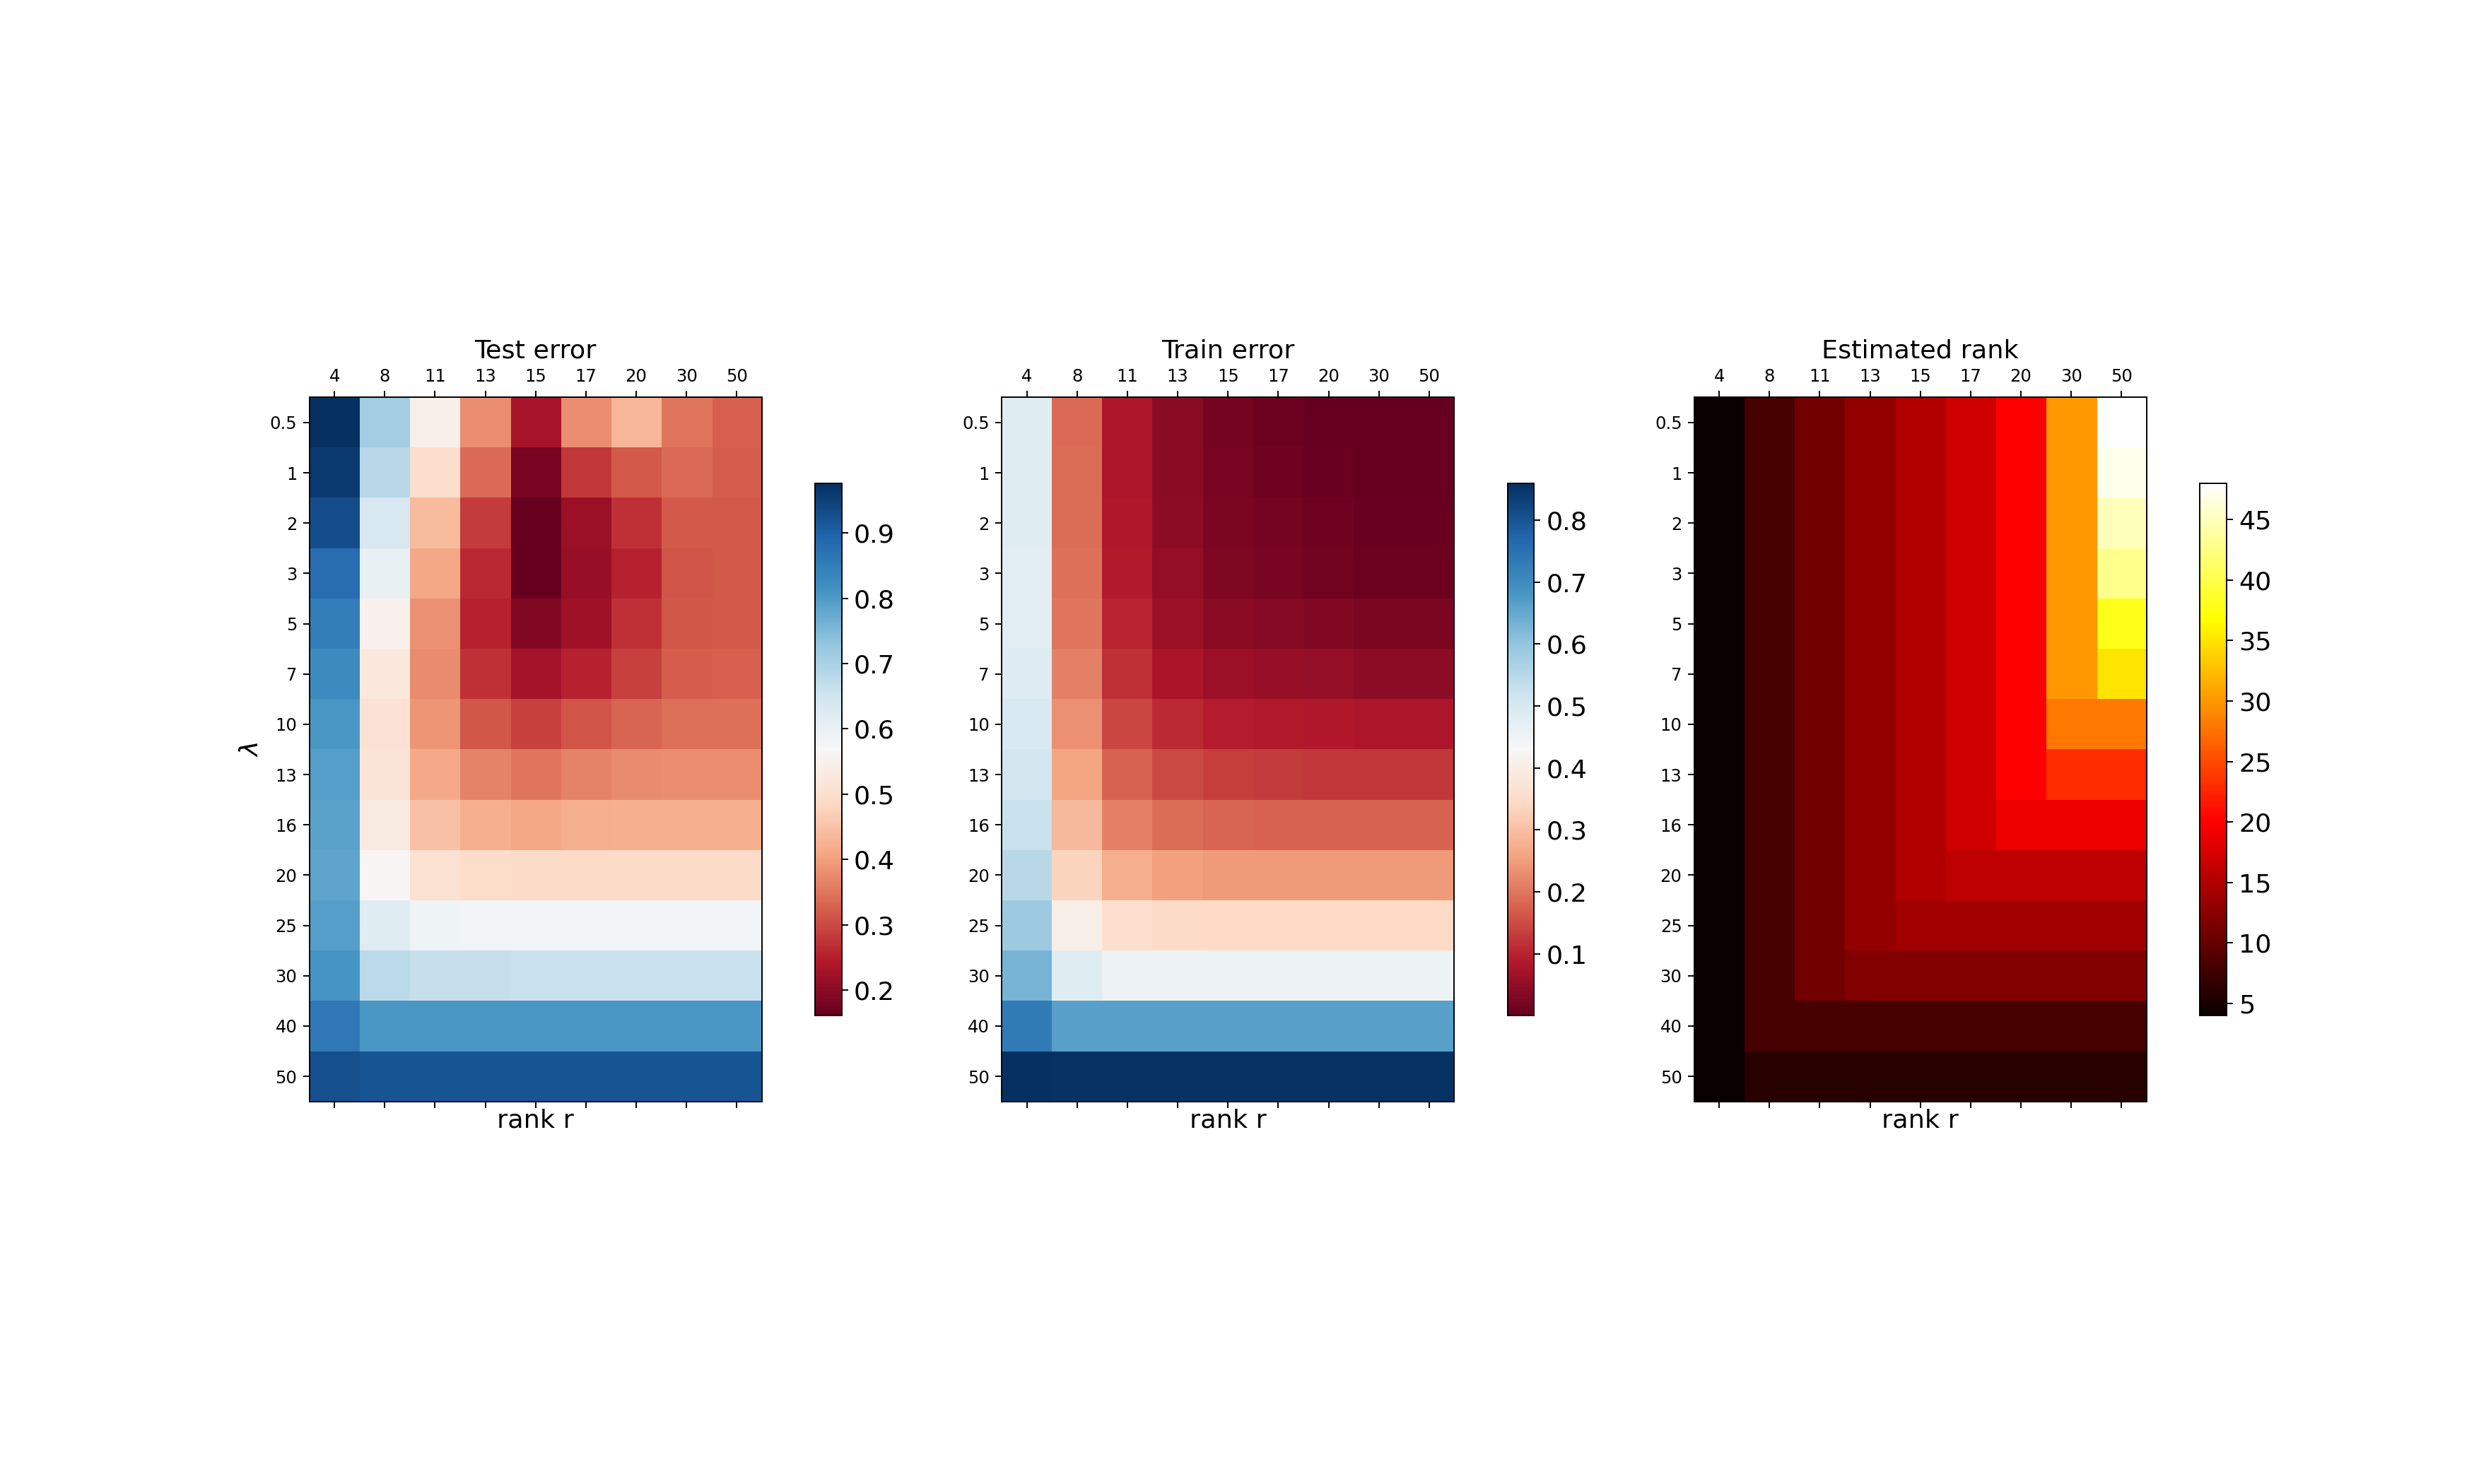

In [17]:
import matplotlib.pyplot as plt
print("minimal test error:",test_error.min())
%matplotlib notebook
fig = plt.figure()
plt.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
d1=ax1.matshow(test_error,cmap='RdBu')


ax1.set_xticks(np.arange(len(Rank)))
ax1.set_xticklabels(Rank,fontsize=10)

ax1.set_yticks(np.arange(len(Lambda)))
ax1.set_yticklabels(Lambda,fontsize=10)
ax1.set_xlabel('rank r',fontsize=15)
ax1.set_ylabel('$\lambda$',fontsize=15)
ax1.set_title('Test error',fontsize=15)

d2=ax2.matshow(train_error,cmap='RdBu')
ax2.set_xticks(np.arange(len(Rank)))
ax2.set_xticklabels(Rank,fontsize=10)

ax2.set_yticks(np.arange(len(Lambda)))
ax2.set_yticklabels(Lambda,fontsize=10)
ax2.set_xlabel('rank r',fontsize=15)
ax2.set_title('Train error',fontsize=15)

d3 = ax3.matshow(est_rank,cmap='hot')
ax3.set_xticks(np.arange(len(Rank)))
ax3.set_xticklabels(Rank,fontsize=10)

ax3.set_yticks(np.arange(len(Lambda)))
ax3.set_yticklabels(Lambda,fontsize=10)
ax3.set_xlabel('rank r',fontsize=15)
ax3.set_title('Estimated rank',fontsize=15)
plt.rcParams.update({'font.size': 15})
plt.colorbar(d2,ax=ax2,fraction=0.05, pad=0.1)
plt.colorbar(d1,ax=ax1,fraction=0.05, pad=0.1)
plt.colorbar(d3,ax=ax3,fraction=0.05, pad=0.1)
plt.rcParams['figure.figsize'] = (20.0, 12.0)
plt.savefig('test_train_error_ALS.png',dpi=300)
plt.show()

In [33]:
%%capture
train_error_svd = np.zeros((len(Lambda),))
test_error_svd = np.zeros((len(Lambda),))
train_error_svd_r = np.zeros((len(Lambda),))
test_error_svd_r = np.zeros((len(Lambda),))

est_rank_svd = np.zeros((len(Lambda),))
for i in range(train_error.shape[0]):
    print("current Lambda:",Lambda[i])
    SoftImputer_SVD = SoftImpute_SVD_dense(
            X, Lambda=Lambda[i], r=100, sc='variable')
    SoftImputer_SVD.matrix_completion(
            rvar_eps=1e-9, robj_eps=1e-9, max_iter=3000)
    X_est = SoftImputer_SVD.M
    rank = np.where(SoftImputer_SVD.Dsq.diagonal()>=1e-10)[0].shape[0]
    a,U = post_processing(X,SoftImputer_SVD.U,SoftImputer_SVD.V,rank)
    U_r = U[:,:rank]
    V_r = SoftImputer_SVD.V[:,:rank]
    D_r = np.diag(a[:rank,0])
    X_est_r=U_r.dot(D_r.dot(V_r.T))
    
    est_rank_svd[i] = np.where(SoftImputer_SVD.Dsq.diagonal()>=1e-10)[0].shape[0]
    train_error_svd[i] = calculate_train_error(X, X_est)
    test_error_svd[i] = calculate_test_error(X, true_A, true_B, X_est)
    train_error_svd_r[i] = calculate_train_error(X, X_est_r)
    test_error_svd_r[i] = calculate_test_error(X, true_A, true_B, X_est_r)

minimal test error: 0.31890703072100923


<IPython.core.display.Javascript object>


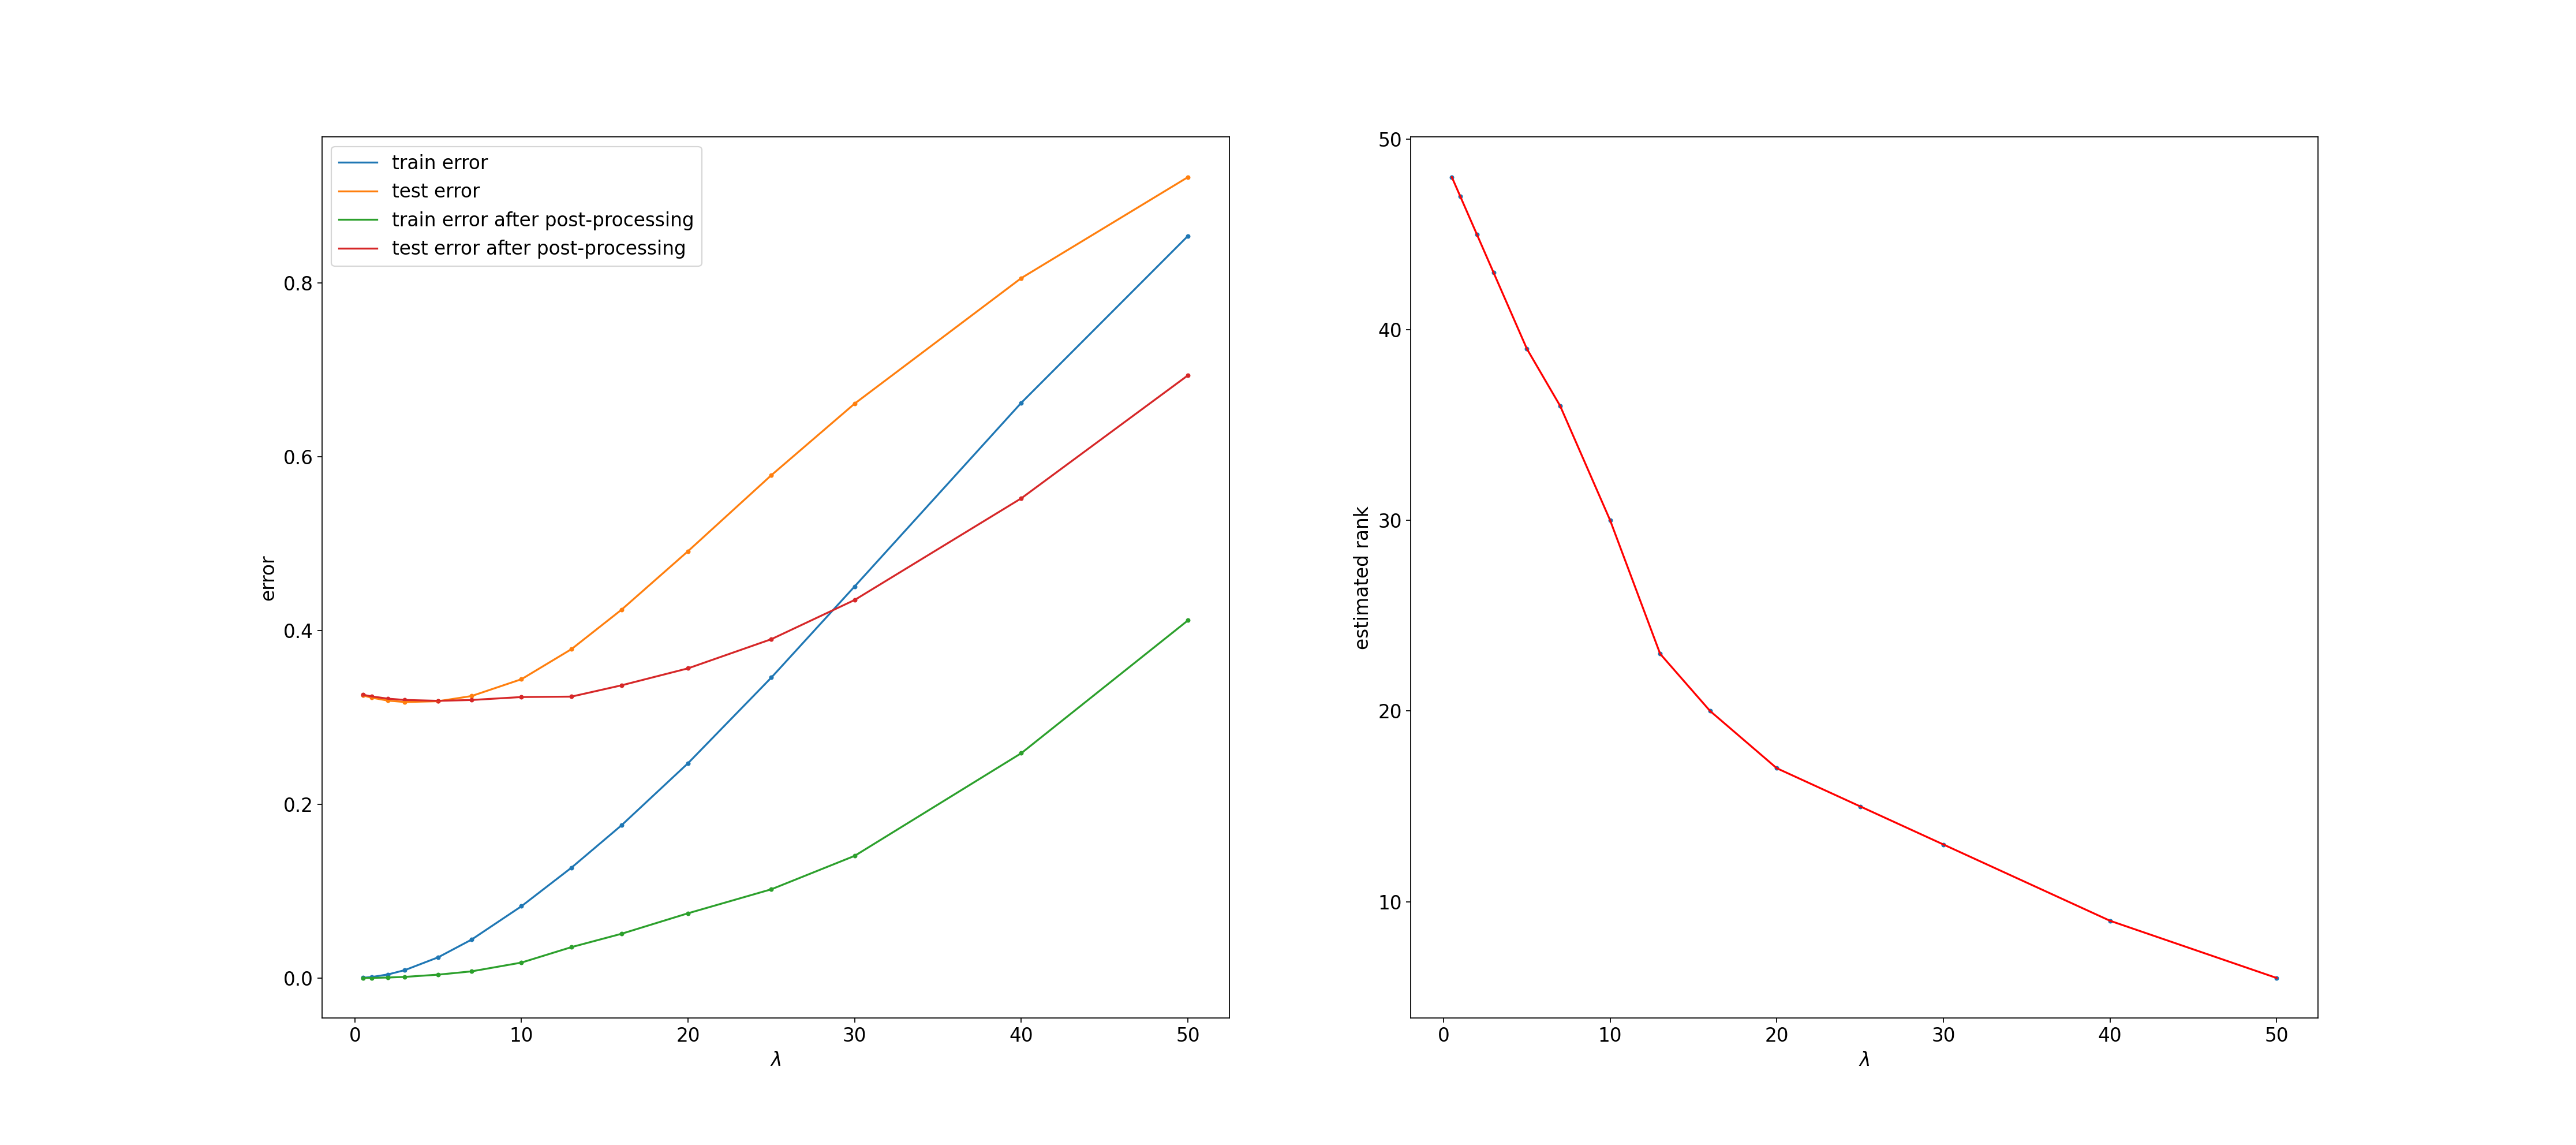

In [34]:
print("minimal test error:",test_error_svd_r.min())
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(Lambda,train_error_svd,label='train error')
ax1.scatter(Lambda,train_error_svd,s=7)
ax1.plot(Lambda,test_error_svd,label='test error')
ax1.scatter(Lambda,test_error_svd,s=7)
ax1.plot(Lambda,train_error_svd_r,label='train error after post-processing')
ax1.scatter(Lambda,train_error_svd_r,s=7)
ax1.plot(Lambda,test_error_svd_r,label='test error after post-processing')
ax1.scatter(Lambda,test_error_svd_r,s=7)
plt.rcParams.update({'font.size': 15})
ax1.legend()
ax1.set_xlabel('$\lambda$',fontsize=15)
ax1.set_ylabel('error',fontsize=15)
ax2 = fig.add_subplot(122)
ax2.plot(Lambda,est_rank_svd,c='r')
ax2.scatter(Lambda,est_rank_svd,s=7)
ax2.set_xlabel('$\lambda$',fontsize=15)
ax2.set_ylabel('estimated rank',fontsize=15)
plt.rcParams['figure.figsize'] = (18.0, 8.0)
# plt.savefig('test_train_error_SVD.png',dpi=300)
plt.show()

Case II: we set SNR=0.1. In this case, both two algorithms have much smaller test error.

In [24]:
X, true_A, true_B = generate_X_AB(m=100, n=100, r=15, prop=0.5, random_state=1)
X += np.random.normal(scale=0.1, size=(100, 100))

Lambda = [0.01,0.05,0.1,0.2,0.5, 1, 2, 3, 5, 7, 16, 25, 35, 50]

Rank = [4, 8, 11, 13, 15, 17, 20, 30, 50]
print("Lambda:", Lambda)
print("Rank:",Rank)

Lambda: [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 3, 5, 7, 16, 25, 35, 50]
Rank: [4, 8, 11, 13, 15, 17, 20, 30, 50]


In [25]:
%%capture
train_error_svd = np.zeros((len(Lambda),))
test_error_svd = np.zeros((len(Lambda),))
train_error_svd_r = np.zeros((len(Lambda),))
test_error_svd_r = np.zeros((len(Lambda),))

est_rank_svd = np.zeros((len(Lambda),))
for i in range(train_error.shape[0]):
    print("current Lambda:",Lambda[i])
    SoftImputer_SVD = SoftImpute_SVD_dense(
            X, Lambda=Lambda[i], r=100, sc='variable')
    SoftImputer_SVD.matrix_completion(
            rvar_eps=1e-9, robj_eps=1e-9, max_iter=3000)
    X_est = SoftImputer_SVD.M
    rank = np.where(SoftImputer_SVD.Dsq.diagonal()>=1e-10)[0].shape[0]
    a,U = post_processing(X,SoftImputer_SVD.U,SoftImputer_SVD.V,rank)
    U_r = U[:,:rank]
    V_r = SoftImputer_SVD.V[:,:rank]
    D_r = np.diag(a[:rank,0])
    X_est_r=U_r.dot(D_r.dot(V_r.T))
    
    est_rank_svd[i] = np.where(SoftImputer_SVD.Dsq.diagonal()>=1e-10)[0].shape[0]
    train_error_svd[i] = calculate_train_error(X, X_est)
    test_error_svd[i] = calculate_test_error(X, true_A, true_B, X_est)
    train_error_svd_r[i] = calculate_train_error(X, X_est_r)
    test_error_svd_r[i] = calculate_test_error(X, true_A, true_B, X_est_r)

<IPython.core.display.Javascript object>


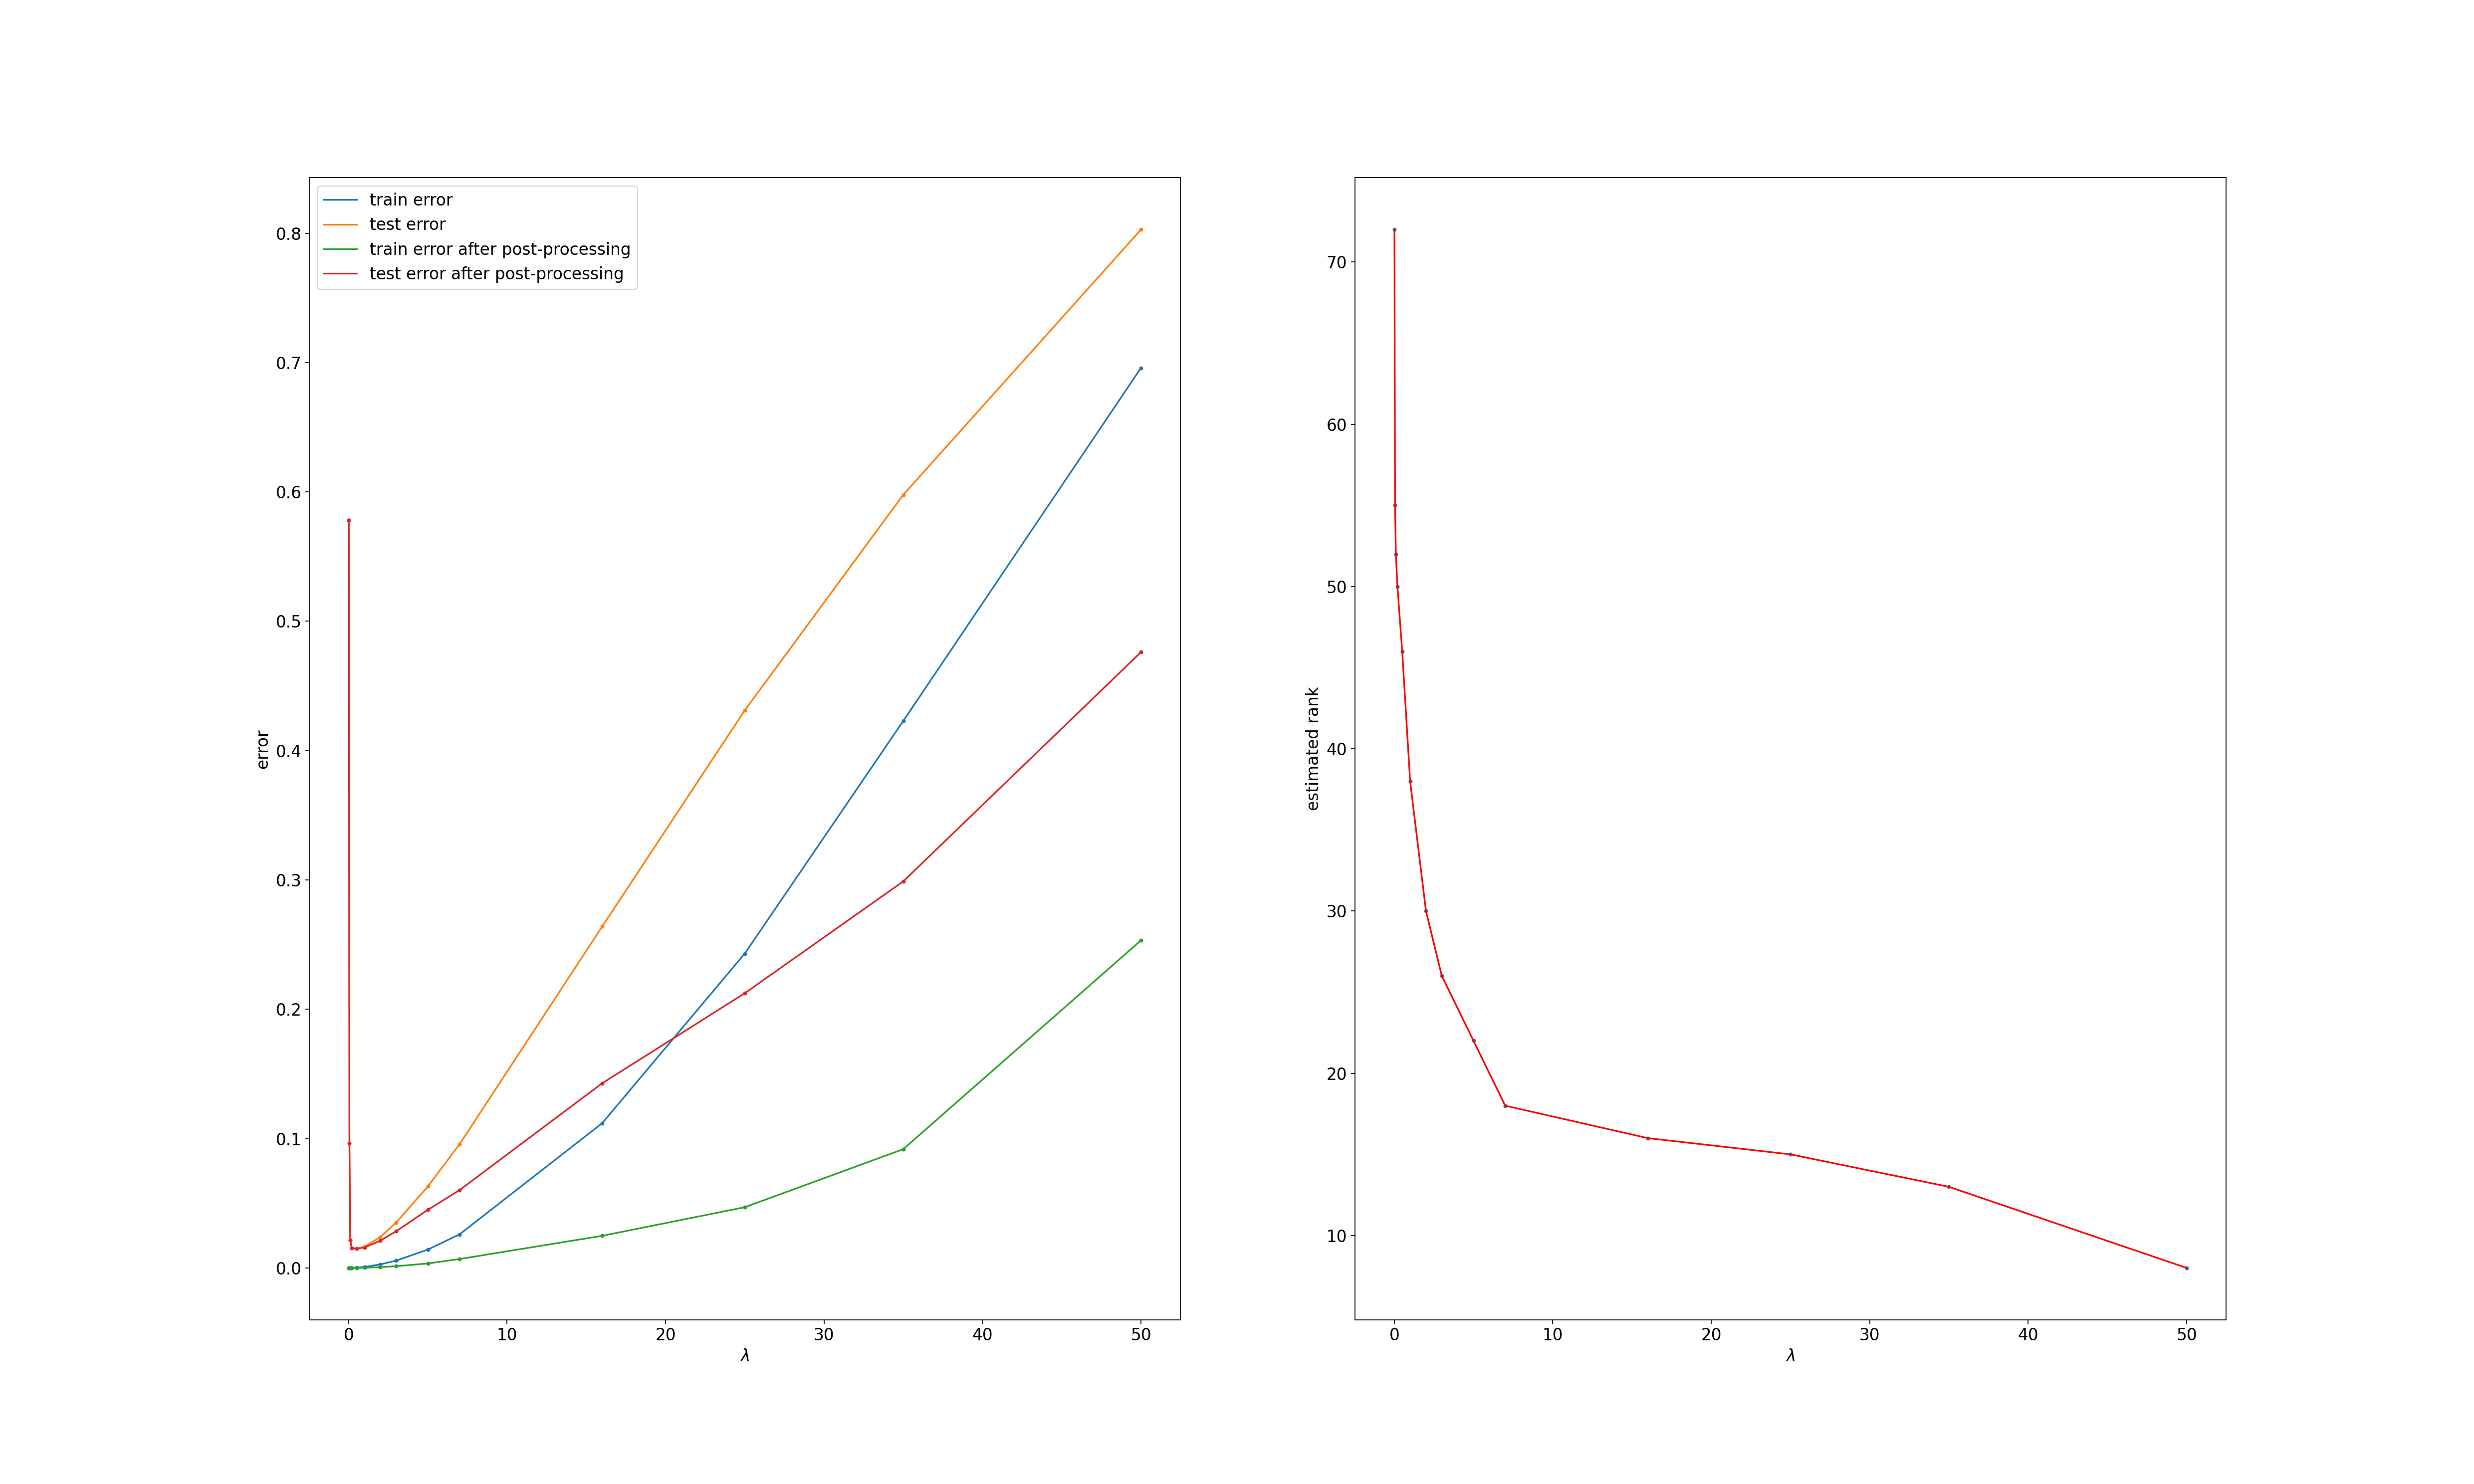

minimal test error: 0.014864205889671191


In [31]:
fig = plt.figure()
print("minimal test error:",test_error_svd_r.min())
ax1 = fig.add_subplot(121)
ax1.plot(Lambda,train_error_svd,label='train error')
ax1.scatter(Lambda,train_error_svd,s=7)
ax1.plot(Lambda,test_error_svd,label='test error')
ax1.scatter(Lambda,test_error_svd,s=7)
ax1.plot(Lambda,train_error_svd_r,label='train error after post-processing')
ax1.scatter(Lambda,train_error_svd_r,s=7)
ax1.plot(Lambda,test_error_svd_r,label='test error after post-processing')
ax1.scatter(Lambda,test_error_svd_r,s=7)
plt.rcParams.update({'font.size': 15})
ax1.legend()
ax1.set_xlabel('$\lambda$',fontsize=15)
ax1.set_ylabel('error',fontsize=15)
ax2 = fig.add_subplot(122)
ax2.plot(Lambda,est_rank_svd,c='r')
ax2.scatter(Lambda,est_rank_svd,s=7)
ax2.set_xlabel('$\lambda$',fontsize=15)
ax2.set_ylabel('estimated rank',fontsize=15)
plt.rcParams['figure.figsize'] = (18.0, 8.0)
# plt.savefig('test_train_error_SVD_case2.png',dpi=300)
plt.show()

In [28]:
%%capture
train_error = np.zeros((len(Lambda), len(Rank)))
test_error = np.zeros((len(Lambda), len(Rank)))
est_rank = np.zeros((len(Lambda), len(Rank)))

for i in range(train_error.shape[0]):
    print("current Lambda:",Lambda[i])
    for j in range(test_error.shape[1]):
        SoftImputer_ALS = SoftImpute_ALS_subspace_dense(
            X, Lambda=Lambda[i], r=Rank[j], sc='variable')
        SoftImputer_ALS.matrix_completion(
            rvar_eps=1e-9, robj_eps=1e-9, max_iter=5000)
        X_est = SoftImputer_ALS.A.dot(SoftImputer_ALS.B.T)
        est_rank[i,j] = np.where(SoftImputer_ALS.Dsq.diagonal()>=1e-10)[0].shape[0]
        train_error[i, j] = calculate_train_error(X, X_est)
        test_error[i, j] = calculate_test_error(X, true_A, true_B, X_est)

minimal test error: 0.0009540839279796031


<IPython.core.display.Javascript object>


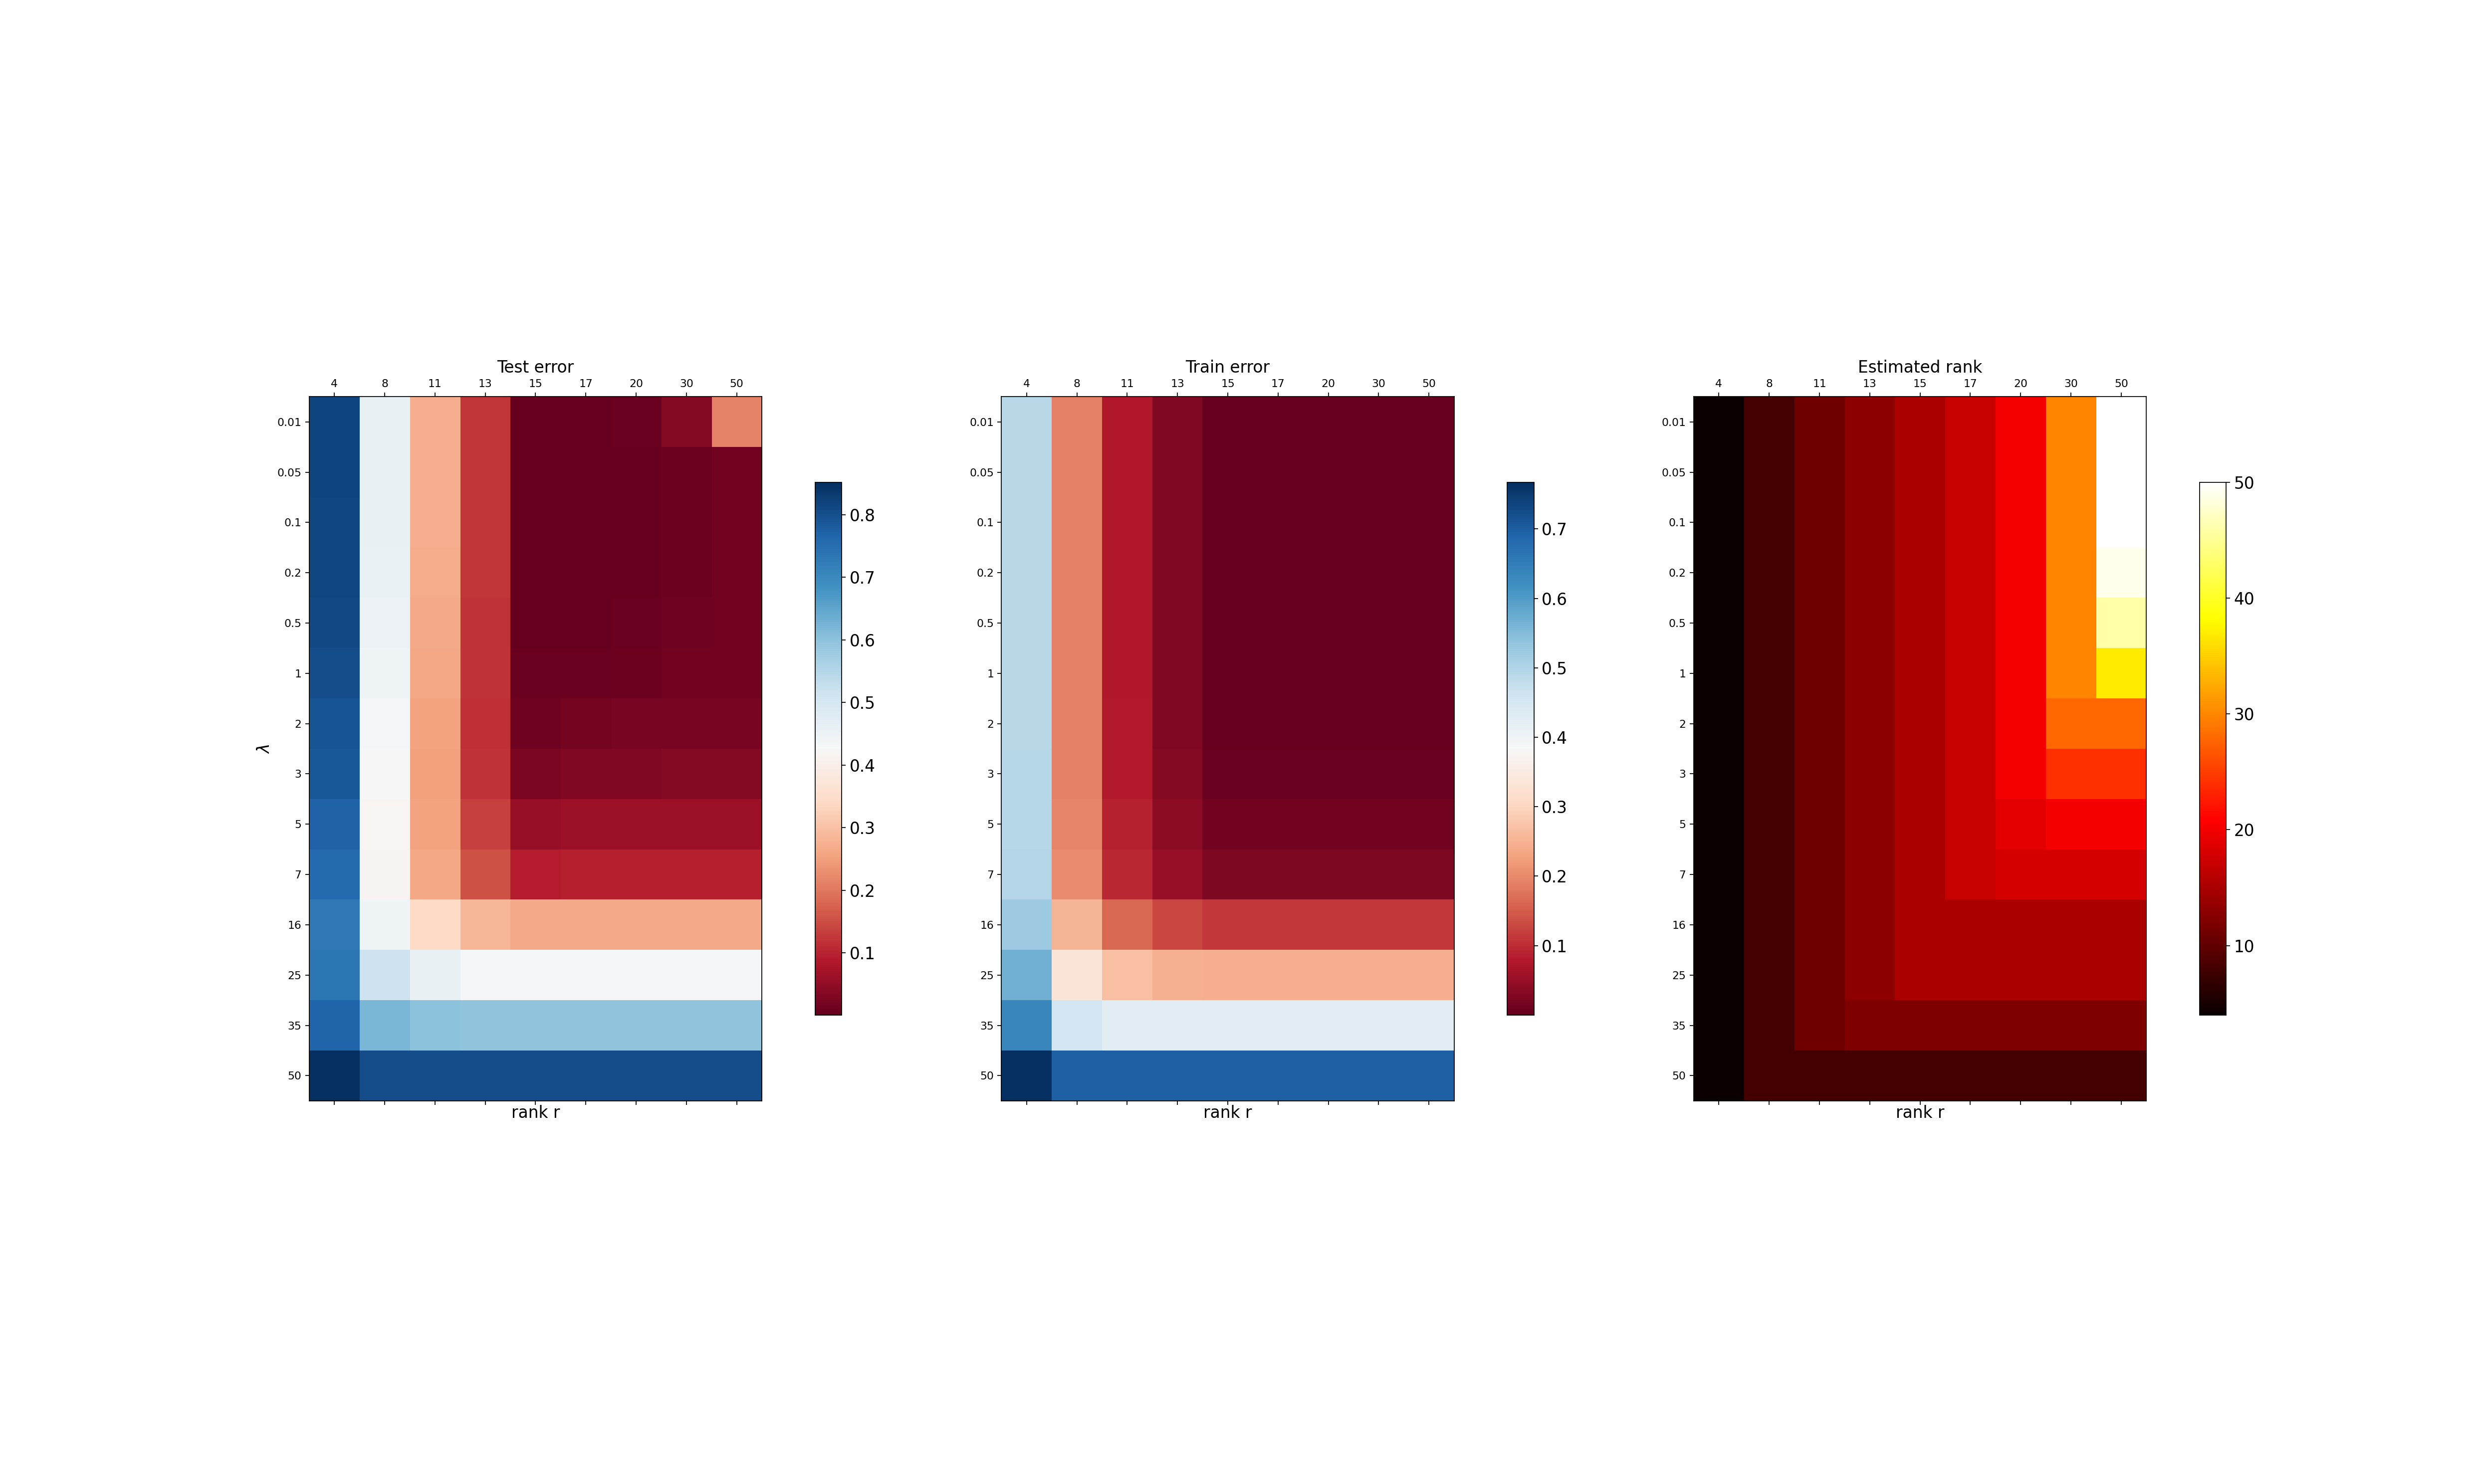

In [30]:
import matplotlib.pyplot as plt
print("minimal test error:",test_error.min())
%matplotlib notebook
fig = plt.figure()
plt.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
d1=ax1.matshow(test_error,cmap='RdBu')


ax1.set_xticks(np.arange(len(Rank)))
ax1.set_xticklabels(Rank,fontsize=10)

ax1.set_yticks(np.arange(len(Lambda)))
ax1.set_yticklabels(Lambda,fontsize=10)
ax1.set_xlabel('rank r',fontsize=15)
ax1.set_ylabel('$\lambda$',fontsize=15)
ax1.set_title('Test error',fontsize=15)

d2=ax2.matshow(train_error,cmap='RdBu')
ax2.set_xticks(np.arange(len(Rank)))
ax2.set_xticklabels(Rank,fontsize=10)

ax2.set_yticks(np.arange(len(Lambda)))
ax2.set_yticklabels(Lambda,fontsize=10)
ax2.set_xlabel('rank r',fontsize=15)
ax2.set_title('Train error',fontsize=15)

d3 = ax3.matshow(est_rank,cmap='hot')
ax3.set_xticks(np.arange(len(Rank)))
ax3.set_xticklabels(Rank,fontsize=10)

ax3.set_yticks(np.arange(len(Lambda)))
ax3.set_yticklabels(Lambda,fontsize=10)
ax3.set_xlabel('rank r',fontsize=15)
ax3.set_title('Estimated rank',fontsize=15)
plt.rcParams.update({'font.size': 15})
plt.colorbar(d2,ax=ax2,fraction=0.05, pad=0.1)
plt.colorbar(d1,ax=ax1,fraction=0.05, pad=0.1)
plt.colorbar(d3,ax=ax3,fraction=0.05, pad=0.1)
plt.rcParams['figure.figsize'] = (20.0, 12.0)
plt.savefig('test_train_error_ALS_case2.png',dpi=300)
plt.show()